## Section 6 - Evaluation Part 1 
The following script presents the first use case from Section 6 Part 1 – Evaluation in the manuscript where we simulate the current IBM quantum cloud. 

In [1]:
from QCloud import *
import statistics
from collections import defaultdict
import math
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
import random

def print_result(job_records, LAMBDA): 
    finished = defaultdict(int)
    unfinished = defaultdict(int)
    wait_time = defaultdict(list)
    never_assigned = 0
    fidelity = defaultdict(list)

    avg_fidelity = defaultdict(int)
    std_fidelity = defaultdict(int)
    avg_waittime = defaultdict(int)
    std_waittime = defaultdict(int)

    for events in job_records.values():
        if 'arrival' in events and 'devc_start' in events and 'devc_finish' in events:            
            devc_name = events['devc_name'] 
            finished[devc_name] += 1
            wait_time_diff = events['devc_finish']-events['devc_start']
            wait_time[devc_name].append(wait_time_diff)
        elif 'arrival' in events and 'devc_start' in events and 'devc_finish' not in events:
            devc_name = events['devc_name']
            unfinished[devc_name] += 1        
        elif 'arrival' in events and 'devc_start' not in events:        
            never_assigned += 1
        if 'fidelity' in events: 
            devc_name = events['devc_name']
            fidelity[devc_name].append(events['fidelity'])


    
    total_job_processed = 0
    with open(f"results/counted-jobs-lambda-{LAMBDA}.txt", "w") as file:
        file.write(f"LAMBDA: {LAMBDA}\n")

        for key in finished.keys(): 
            avg_fidelity[key] = statistics.mean(fidelity[key])
            std_fidelity[key] = statistics.stdev(fidelity[key])
            avg_waittime[key] = round(statistics.mean(wait_time[key]), 4)
            std_waittime[key] = round(statistics.stdev(wait_time[key]), 4)

            total_job_processed += finished[key]
            
            # print(f"device name: {key}, finished: {finished[key]}, avg_fidelity: {avg_fidelity[key]:.4f} +/- {std_fidelity[key]:.4f}, avg_waittime: {avg_waittime[key]:.4f} +/- {std_waittime[key]:.4f}")    
            file.write(f"device name: {key}, processed jobs by machine: {finished[key]}, avg_fidelity: {avg_fidelity[key]:.4f} +/- {std_fidelity[key]:.4f}, avg_waittime: {avg_waittime[key]:.4f} +/- {std_waittime[key]:.4f}\n")
        print(f"LAMBDA: {LAMBDA} | Total job processed: {total_job_processed} | Never Assigned: {never_assigned}", )    
        file.write(f"Total job processed: {total_job_processed} | Never Assigned: {never_assigned}\n")
          
    sorted_finished = {key: finished[key] for key in sorted(finished, key=lambda x: int(x))}
    sorted_avg_waittime = {key: avg_waittime[key] for key in sorted(avg_waittime, key=lambda x: int(x))}
    sorted_avg_fidelity = {key: avg_fidelity[key] for key in sorted(avg_fidelity, key=lambda x: int(x))} 
    sorted_std_fidelity = {key: std_fidelity[key] for key in sorted(std_fidelity, key=lambda x: int(x))}
    
    throughput = list(sorted_finished.values())
    wait_time = list(sorted_avg_waittime.values())
    avg_fidelity = list(sorted_avg_fidelity.values())
    std_fidelity = list(sorted_std_fidelity.values())
    
    print("processed jobs by machine:", throughput)
    print("wait_time:", wait_time)
    
    return total_job_processed, never_assigned, throughput, wait_time, avg_fidelity, std_fidelity

In [2]:
## BEGINNING OF THE SIMULATION
sim_start_time = time.time()
LAMBDAS = [0.5, 1, 2, 3, 4, 5, 6]

processed = defaultdict(list)
notprocessed = defaultdict(list)
tot_troughput = defaultdict(list)
avg_wait_time = defaultdict(list)
avg_fidelity_ = defaultdict(int)
std_fidelity_ = defaultdict(int)
SAVE_RAW_DATA = False

for i in range(3): 
    for LAMBDA in LAMBDAS: 
        # Create quantum devices
        ibm_kawasaki = IBM_Kawasaki(env=None, name="1", printlog = False)
        ibm_kyiv = IBM_Kyiv(env=None, name="2", printlog = False)
        ibm_sherbrooke = IBM_Sherbrooke(env=None, name="3", printlog = False)
        ibm_quebec = IBM_Quebec(env=None, name="4", printlog = False)
        ibm_rensselaer = IBM_Rensselaer(env=None, name="5", printlog = False)
        ibm_brisbane = IBM_Brisbane(env=None, name="6", printlog = False)        
        ibm_brussels = IBM_Brussels(env=None, name="7", printlog = False)
        ibm_strasbourg = IBM_Strasbourg(env=None, name="8", printlog = False)        
        ibm_marrakesh = IBM_Marrakesh(env=None, name="9", printlog = False) 
        ibm_fez = IBM_Fez(env=None, name="10", printlog = False)
        ibm_torino = IBM_Torino(env=None, name="11", printlog = False)


        expovar_model = lambda: random.expovariate(lambd=LAMBDA)
        devices = [ibm_kawasaki, ibm_kyiv, ibm_sherbrooke, ibm_quebec, ibm_rensselaer, 
                  ibm_brisbane, ibm_brussels, ibm_strasbourg, ibm_marrakesh, ibm_fez, ibm_torino]

        start_time = time.time() # Start the timer

        # Initialize and run the simulation using jobs from a CSV file
        qcloudsimenv = QCloudSimEnv(
            devices=devices,
            broker_class=ParallelBroker,
            job_feed_method="generator",
            job_generation_model=expovar_model
        )
        qcloudsimenv.run(until=1008)

        end_time = time.time() # End the timer
        elapsed_time = end_time - start_time # Calculate elapsed time

        print(f"Elapsed time: {elapsed_time:.5f} seconds\n")
        # Access job records after the simulation
        job_records = qcloudsimenv.job_records_manager.get_job_records()

        # If you want to save raw data, set the parameter to True
        if SAVE_RAW_DATA: 
            with open(f"results/raw_records-lambda-{LAMBDA}.txt", "w") as file:
                file.write(f"Elapsed time: {elapsed_time:.5f} seconds\n")
                for job_id, events in job_records.items():
                    # Write each job record to the file               
                    file.write(f"Job ID: {job_id}, Events: {events}\n")
                    
        processedjobs, notprocessedjobs, throughput, wait_time, avg_fidelity, std_fidelity = print_result(job_records, LAMBDA)
        processed[LAMBDA] = processedjobs
        notprocessed[LAMBDA] = notprocessedjobs
        tot_troughput[LAMBDA] = throughput
        avg_wait_time[LAMBDA] = wait_time
        avg_fidelity_[LAMBDA] = avg_fidelity
        std_fidelity_[LAMBDA] = std_fidelity
        
sim_end_time = time.time() # End the timer
sim_elapsed_time = sim_end_time - sim_start_time # Calculate elapsed time

print(f"Elapsed time: {sim_elapsed_time:.5f} seconds")

Elapsed time: 0.74639 seconds

LAMBDA: 0.5 | Total job processed: 426 | Never Assigned: 32
processed jobs by machine: [30, 29, 35, 32, 38, 39, 47, 59, 34, 42, 41]
wait_time: [203.8677, 218.004, 192.9279, 170.6298, 191.4987, 37.4103, 26.6627, 28.4785, 32.3152, 32.0626, 31.2358]
Elapsed time: 1.32969 seconds

LAMBDA: 1 | Total job processed: 715 | Never Assigned: 234
processed jobs by machine: [28, 36, 36, 40, 37, 71, 98, 82, 96, 102, 89]
wait_time: [228.8649, 220.3011, 200.2744, 194.165, 204.1907, 35.1249, 31.1193, 30.0746, 30.6986, 35.2341, 26.8388]
Elapsed time: 1.88300 seconds

LAMBDA: 2 | Total job processed: 1259 | Never Assigned: 707
processed jobs by machine: [35, 39, 30, 40, 33, 172, 167, 177, 209, 187, 170]
wait_time: [213.2343, 198.9012, 251.7021, 198.644, 229.7734, 35.7515, 28.4981, 29.5991, 34.0748, 33.964, 31.7639]
Elapsed time: 2.79809 seconds

LAMBDA: 3 | Total job processed: 1679 | Never Assigned: 1237
processed jobs by machine: [30, 30, 41, 34, 39, 231, 268, 263, 249, 2

### Plotting Figure 6

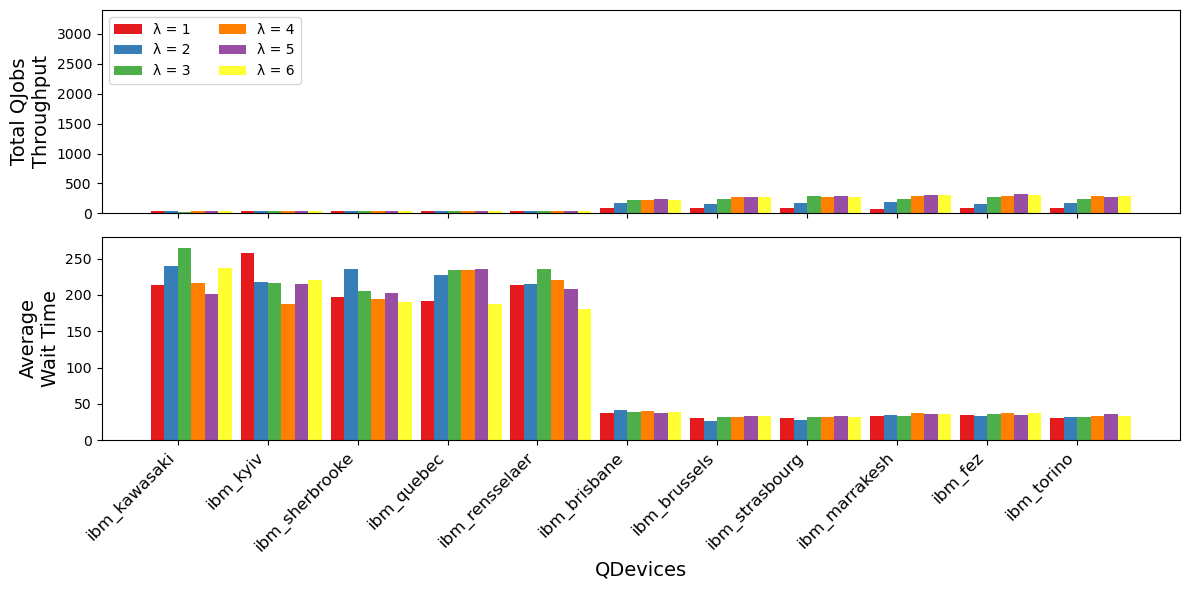

In [3]:
device_names = ["ibm_kawasaki", "ibm_kyiv", "ibm_sherbrooke", "ibm_quebec", "ibm_rensselaer", 
"ibm_brisbane", "ibm_brussels", "ibm_strasbourg", "ibm_marrakesh", "ibm_fez", "ibm_torino"]

# Settings
datasets1 = [tot_troughput[1], tot_troughput[2], tot_troughput[3], tot_troughput[4], tot_troughput[5], tot_troughput[6]]
datasets2 = [avg_wait_time[1], avg_wait_time[2], avg_wait_time[3], avg_wait_time[4], avg_wait_time[5], avg_wait_time[6]]
labels = ['λ = 1', 'λ = 2', 'λ = 3', 'λ = 4', 'λ = 5', 'λ = 6']
colors = ["#E41A1C", "#377EB8", "#4DAF4A", "#FF7F00", "#984EA3", "#FFFF33"]

num_devices = len(device_names)
x = np.arange(num_devices)
width = 0.15

# Create vertically stacked subplots
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 6), sharex=True)

# ----- Plot 1: Total QJobs Throughput -----
for i, dataset in enumerate(datasets1):
    axs[0].bar(x + i * width, dataset, width, label=labels[i], color=colors[i])

axs[0].set_ylabel('Total QJobs\nThroughput', fontsize=14)
axs[0].set_ylim(0, 3400)
axs[0].legend(loc='upper left', bbox_to_anchor=(0, 1), ncol=2)
axs[0].tick_params(axis='x', labelbottom=False)  # hide x labels for top plot

# ----- Plot 2: Average Wait Time -----
for i, df in enumerate(datasets2):
    axs[1].bar(x + i * width, df, width, label=labels[i], capsize=5, color=colors[i])

axs[1].set_xlabel('QDevices', fontsize=14)
axs[1].set_ylabel('Average\nWait Time', fontsize=14)
axs[1].set_ylim(0, 280)
axs[1].set_xticks(x + width * 1.5)
axs[1].set_xticklabels(device_names, rotation=45, ha='right', fontsize=12)

plt.tight_layout()
# plt.savefig("Fig-6-throughput-waittime-IBM.png")
plt.show()

### Plotting Figure 7

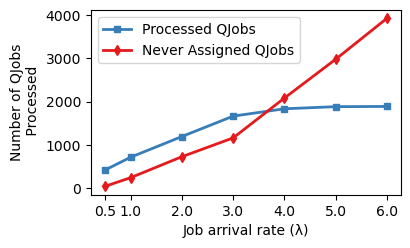

In [4]:
MARKERSIZE = 5
FONTSIZE = 10
# Data
lambdas = [0.5, 1, 2, 3, 4, 5, 6]
processed_jobs = list(processed.values())
not_processed_jobs = list(notprocessed.values())

color = ['#56B4E9', '#E69F00']
# Create the plot
plt.figure(figsize=(4, 2.4))

# Plot the lines for processed and not processed jobs
plt.plot(lambdas, processed_jobs, label='Processed QJobs', marker='s', color="#377EB8", linewidth=2, markersize=MARKERSIZE)
plt.plot(lambdas, not_processed_jobs, label='Never Assigned QJobs', marker='d', color="#E41A1C", linewidth=2, markersize=MARKERSIZE)

# Adding labels and title
plt.xlabel('Job arrival rate (λ)', fontsize=FONTSIZE)
plt.ylabel('Number of QJobs\n Processed', fontsize=FONTSIZE)
plt.xticks(lambdas, fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)

# Add legend
plt.legend(fontsize=FONTSIZE)
# plt.savefig("Fig-7-throughputs.png")
plt.show()

In [5]:
# All average fidelities and standard deviations
avg_fidelities = list(avg_fidelity_.values())
std_devs = list(std_fidelity_.values())

# Flatten the lists
all_fidelities = np.concatenate(avg_fidelities)
all_std_devs = np.concatenate(std_devs)

# Calculate variances
variances = all_std_devs**2

# Calculate weights (w = 1/variance)
weights = 1 / variances

# Calculate weighted average fidelity
weighted_avg_fidelity = np.sum(weights * all_fidelities) / np.sum(weights)

# Calculate overall standard deviation
overall_std_dev = np.sqrt(1 / np.sum(weights))

print(f"Weighted Average Fidelity: {weighted_avg_fidelity:.4f}")
print(f"Overall Standard Deviation: {overall_std_dev:.4f}")

Weighted Average Fidelity: 0.7531
Overall Standard Deviation: 0.0090


## Section 6 - Evaluation Part 2
The following script presents the second use case from Section 6 – Evaluation part 2 in the manuscript where a batch of jobs data is dispatched from a .CSV file to varying number of ibm_strasbourg QPUs. 

In [ ]:
### deploying jobs from CSV file. 

from QCloud import *
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

# Create quantum devices
ibm_strasbourg = IBM_Strasbourg(env=None, name="1", printlog = False)
ibm_strasbourg_2 = IBM_Strasbourg(env=None, name="2", printlog = False)
ibm_strasbourg_3 = IBM_Strasbourg(env=None, name="3", printlog = False)
ibm_strasbourg_4 = IBM_Strasbourg(env=None, name="4", printlog = False)
ibm_strasbourg_5 = IBM_Strasbourg(env=None, name="5", printlog = False)
ibm_strasbourg_6 = IBM_Strasbourg(env=None, name="6", printlog = False)
ibm_strasbourg_7 = IBM_Strasbourg(env=None, name="7", printlog = False)

devices = [ibm_strasbourg, ibm_strasbourg_2, ibm_strasbourg_3, ibm_strasbourg_4, ibm_strasbourg_5, ibm_strasbourg_6, ibm_strasbourg_7]
# devices = [ibm_strasbourg, ibm_strasbourg_2]
# Initialize and run the simulation using jobs from a CSV file

sim_hours = defaultdict(list)
exe_time = defaultdict(list)

for num_device in range(1,8): 
    for _ in range(2): 
        start_time = time.time()        
        qcloudsimenv = QCloudSimEnv(
            devices=devices[0:num_device],
            broker_class=ParallelBroker,
            job_feed_method="dispatcher",
            # file_path="jobs_data.csv"
            file_path="synth_job_batches/jobs_data.csv"
        )
        qcloudsimenv.run()
        
        end_time = time.time() # End the timer
        elapsed_time = end_time - start_time # Calculate elapsed time
        # print(qcloudsimenv.now)
        sim_hours[num_device].append(qcloudsimenv.now)        
        # print(f"Elapsed time: {elapsed_time:.5f} seconds")
        exe_time[num_device].append(round(elapsed_time,5))
    print(f"finish one loop for num devices: {num_device}")    

finish one loop for num devices: 1
finish one loop for num devices: 2
finish one loop for num devices: 3
finish one loop for num devices: 4
finish one loop for num devices: 5


### Calculating Average sim-hour and Average execution time

In [ ]:
avg_sim_hours = []
std_sim_hours = []
avg_exe_time = []
std_exe_time = []

for i in range(1, 8):
    # Compute the average (mean)
    avg_sim_hours.append(round(np.mean(sim_hours[i])/60, 4))
    avg_exe_time.append(np.mean(exe_time[i]))
    # Compute the standard deviation
    std_sim_hours.append(round(np.std(sim_hours[i])/60, 4))
    std_exe_time.append(np.std(exe_time[i]))

In [ ]:
FONTSIZE = 10
# Data
num_machines = [1, 2, 3, 4, 5, 6, 7]
avg_sim_hours = avg_sim_hours
std_sim_hours = std_sim_hours

# Create the plot
plt.figure(figsize=(4, 2.4))
plt.errorbar(num_machines, avg_sim_hours, yerr=std_sim_hours, fmt='.-', 
             capsize=5, capthick=1.5, markersize=6, linewidth=2, label="Simulation Time")

# Labels and title
plt.xlabel("Number of Machines", fontsize=FONTSIZE)
plt.ylabel("Simulation Hours", fontsize=FONTSIZE)
plt.show()
# plt.savefig("Fig-8-simulation_time_vs_machines.png")

### Calculating total execution time

In [ ]:
total_mins = 0
for t in avg_exe_time: 
    total_mins +=(t/60)
print(f'Total Execution Time: {total_mins} minute')